C:\Users\matth\AppData\Local\Temp\ipykernel_19648\1260175122.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['sex'] = label_encoder.fit_transform(data2['sex'])
C:\Users\matth\AppData\Local\Temp\ipykernel_19648\1260175122.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['is_smoking'] = label_encoder.fit_transform(data2['is_smoking'])


14/14 [==============================] - 0s 2ms/step


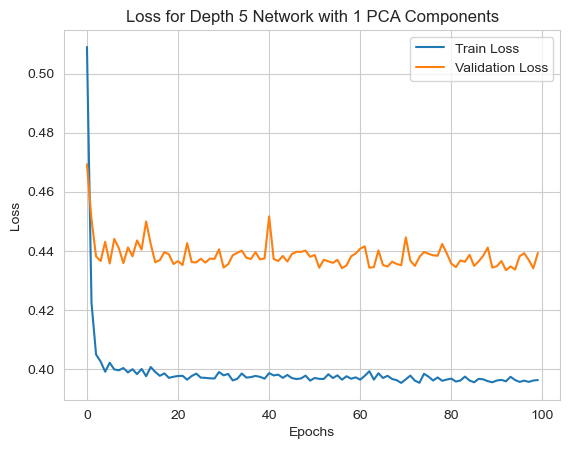

14/14 [==============================] - 0s 1ms/step


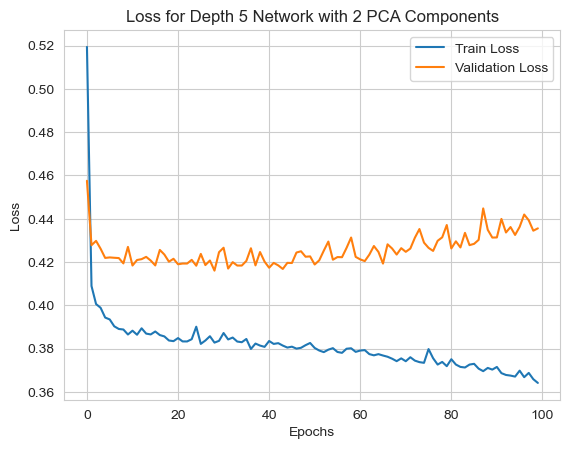

14/14 [==============================] - 0s 1ms/step


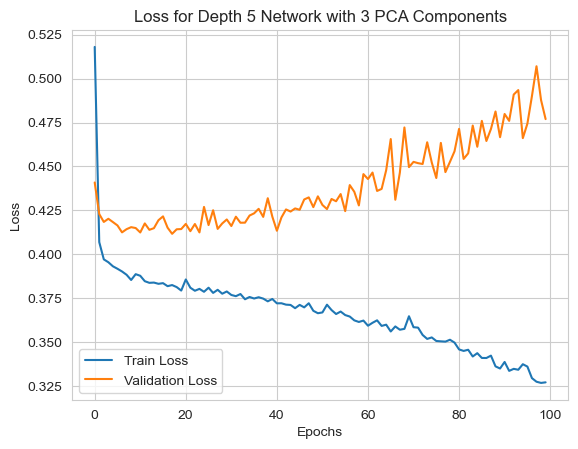

14/14 [==============================] - 0s 2ms/step


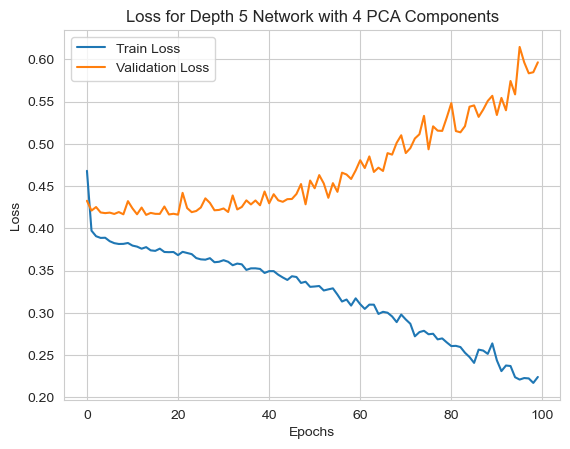

14/14 [==============================] - 0s 1ms/step


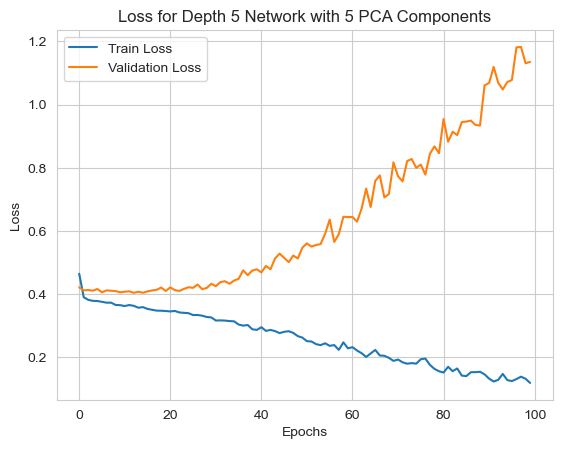

14/14 [==============================] - 0s 2ms/step


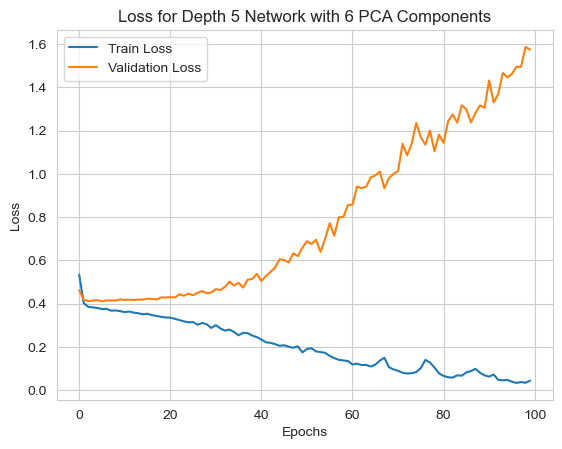

14/14 [==============================] - 0s 1ms/step


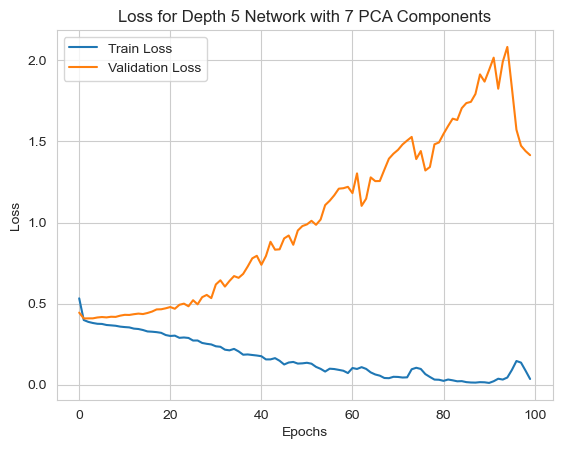

14/14 [==============================] - 0s 1ms/step


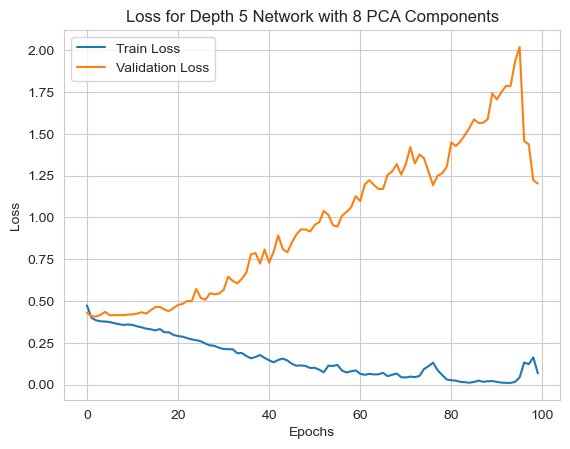

14/14 [==============================] - 0s 1ms/step


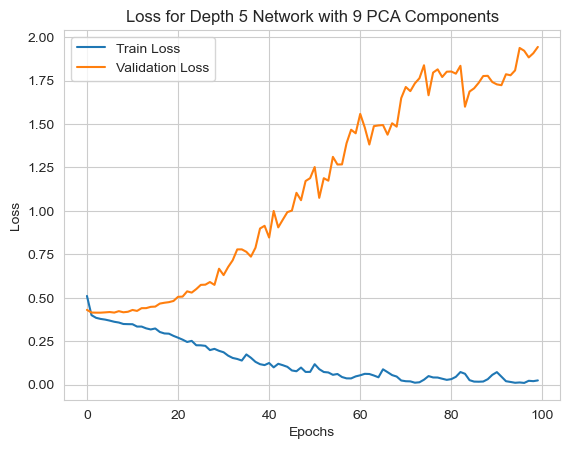

14/14 [==============================] - 0s 2ms/step


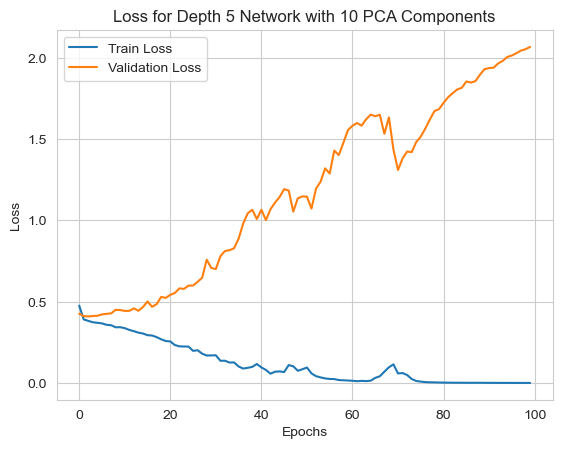

14/14 [==============================] - 0s 1ms/step


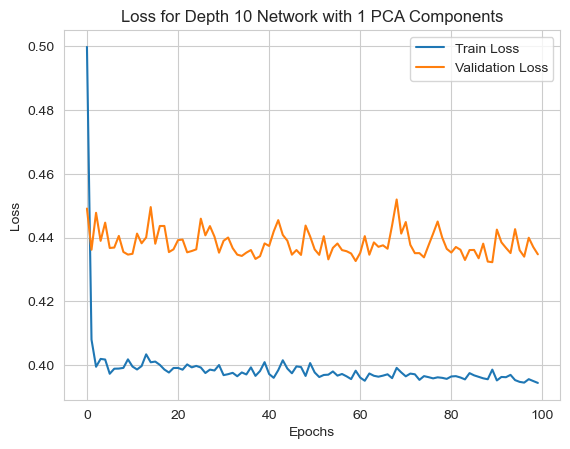

14/14 [==============================] - 0s 924us/step


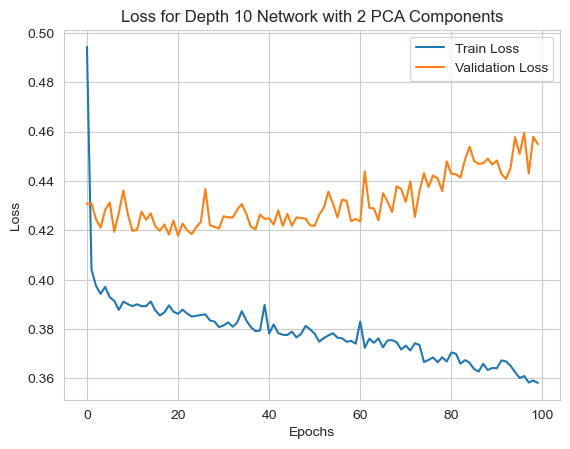

14/14 [==============================] - 0s 1ms/step


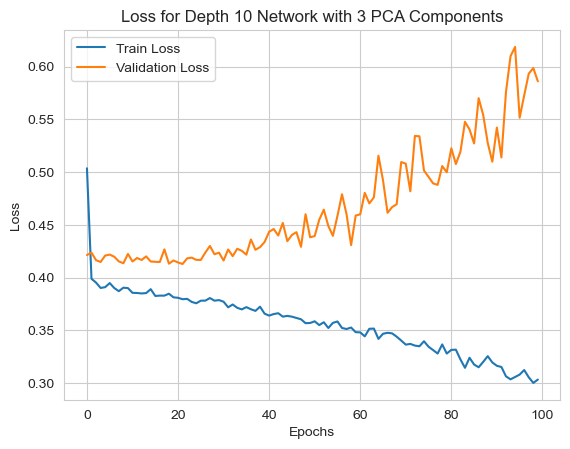

14/14 [==============================] - 0s 1ms/step


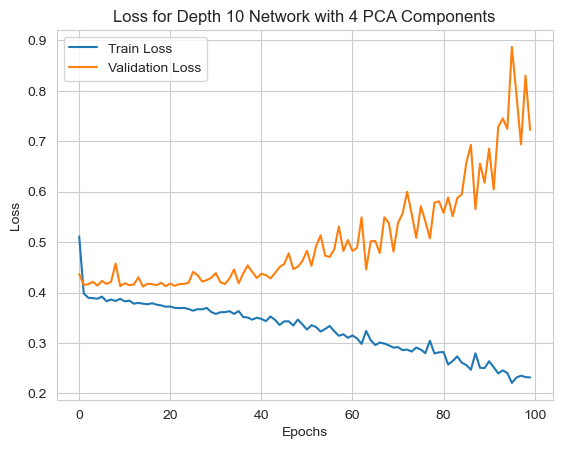

14/14 [==============================] - 0s 1ms/step


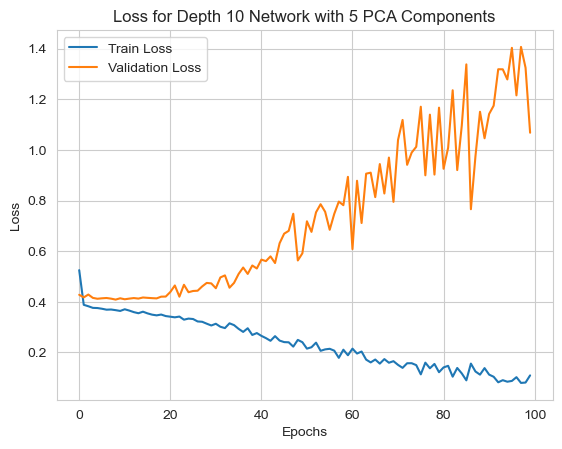

14/14 [==============================] - 0s 1ms/step


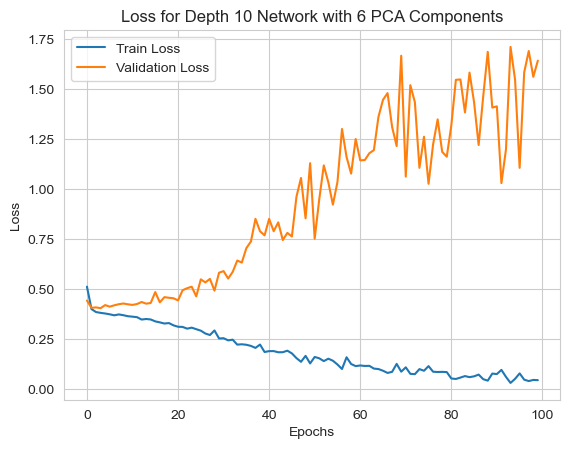

14/14 [==============================] - 0s 2ms/step


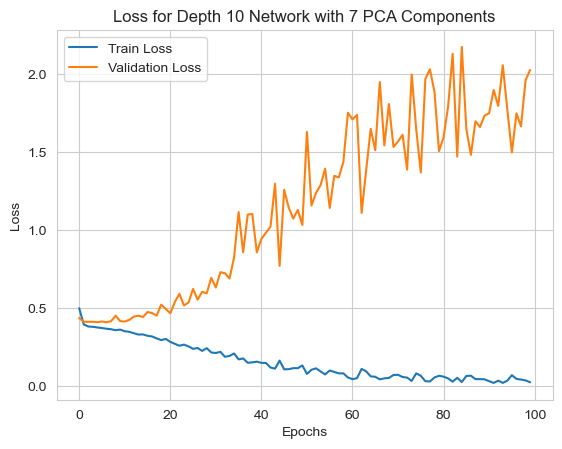

14/14 [==============================] - 0s 1ms/step


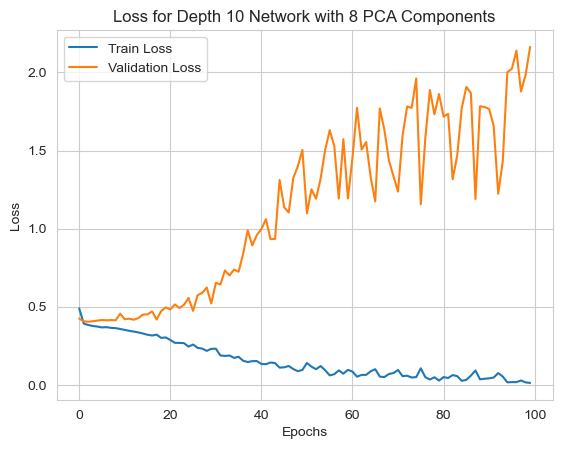

14/14 [==============================] - 0s 889us/step


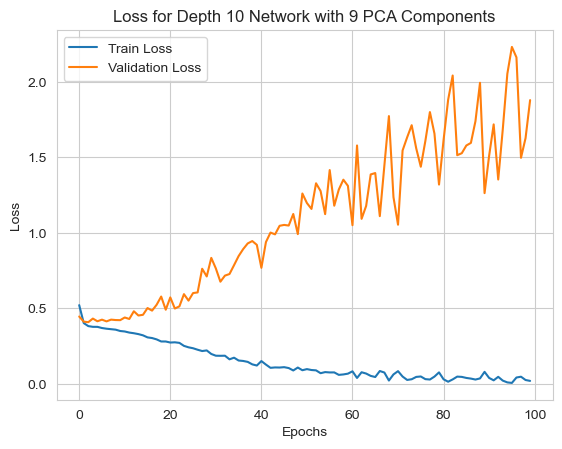

14/14 [==============================] - 0s 1ms/step


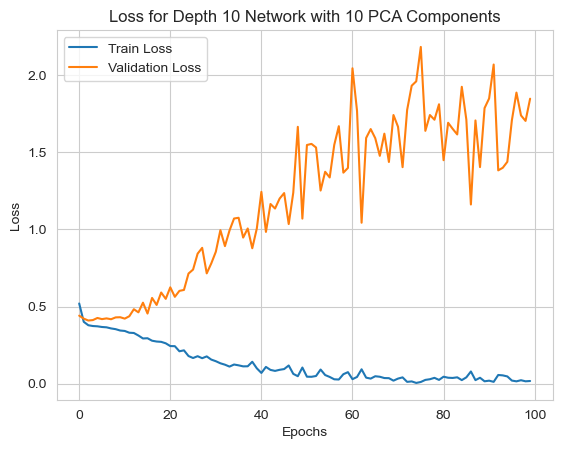

14/14 [==============================] - 0s 1ms/step


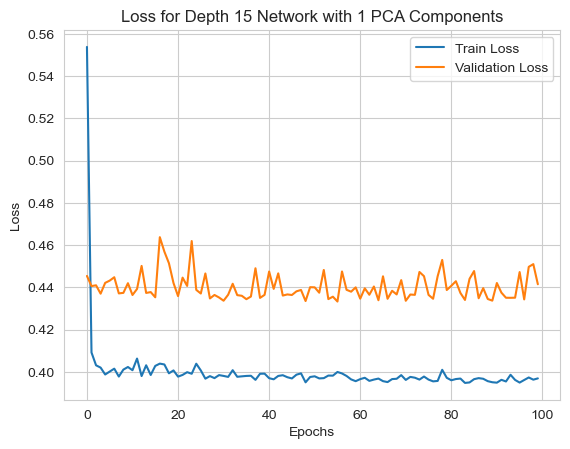

14/14 [==============================] - 0s 2ms/step


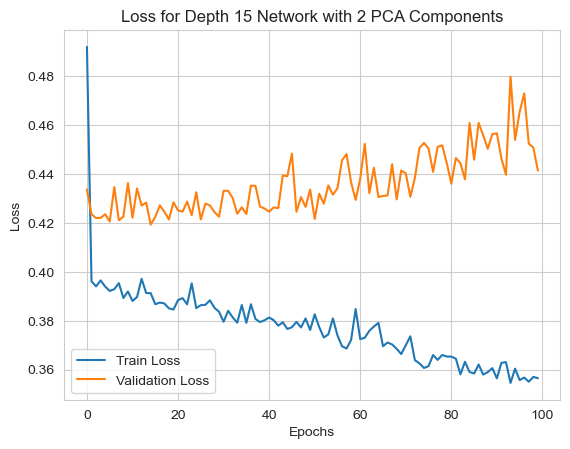

14/14 [==============================] - 0s 2ms/step


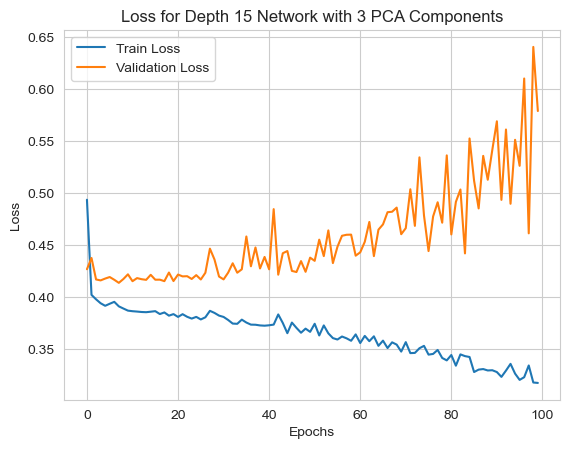

14/14 [==============================] - 0s 2ms/step


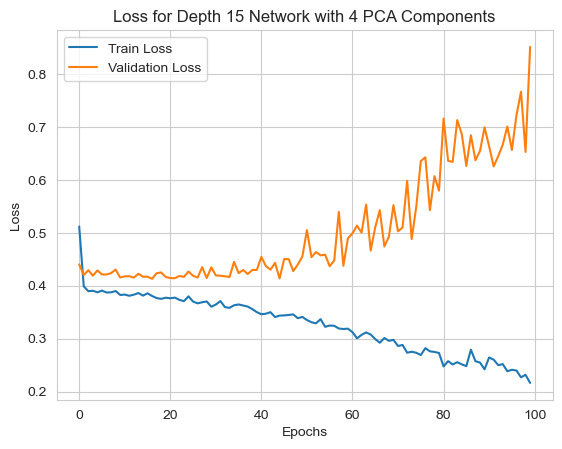

14/14 [==============================] - 0s 2ms/step


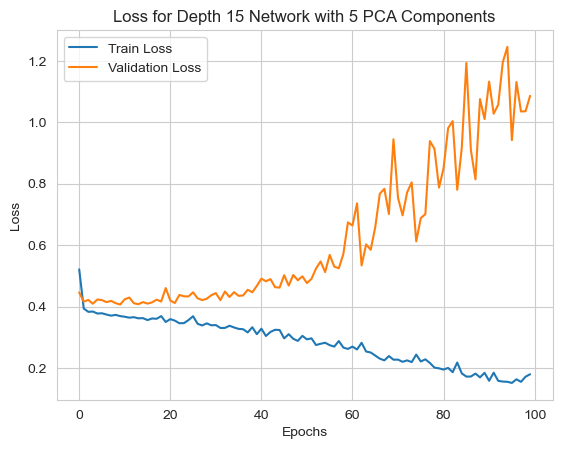

14/14 [==============================] - 0s 1ms/step


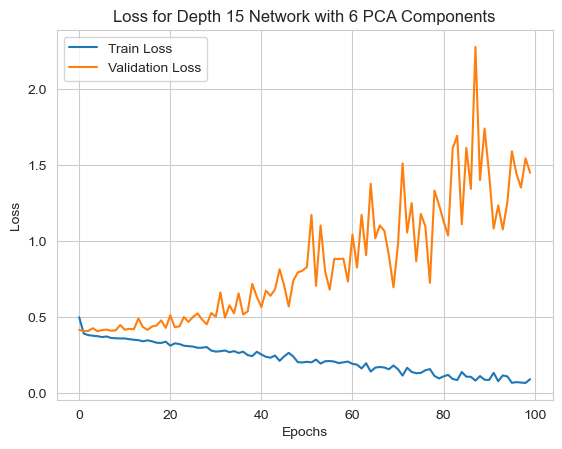

14/14 [==============================] - 0s 2ms/step


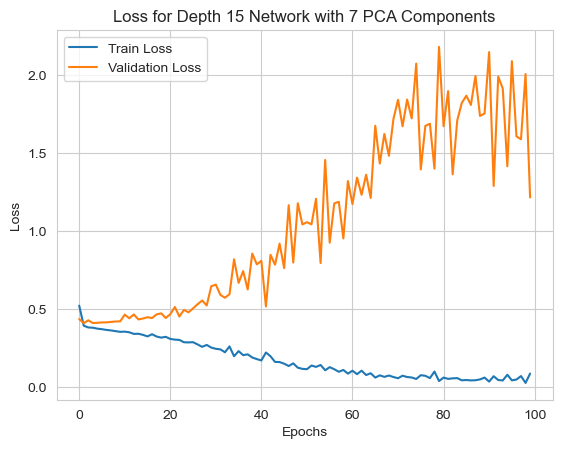

14/14 [==============================] - 0s 2ms/step


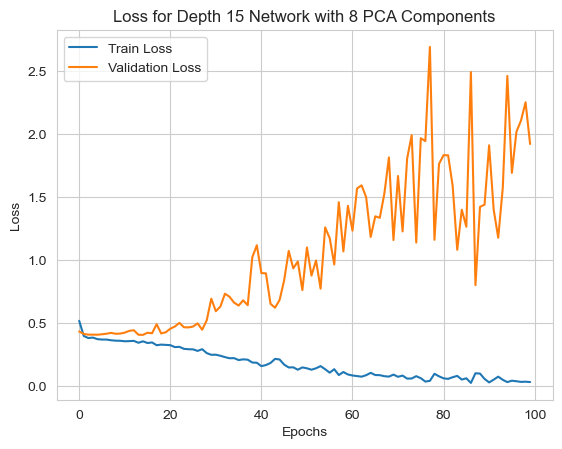

14/14 [==============================] - 0s 2ms/step


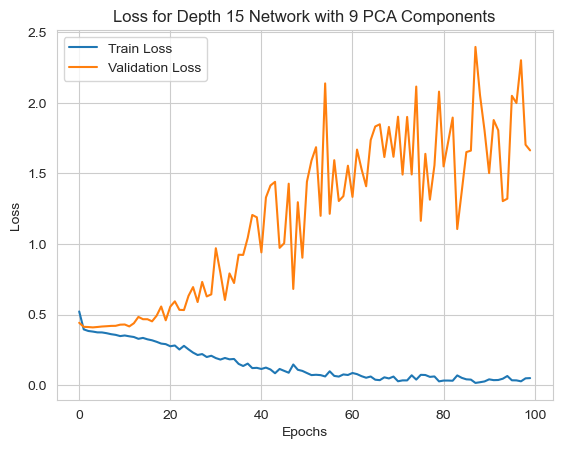

14/14 [==============================] - 0s 2ms/step


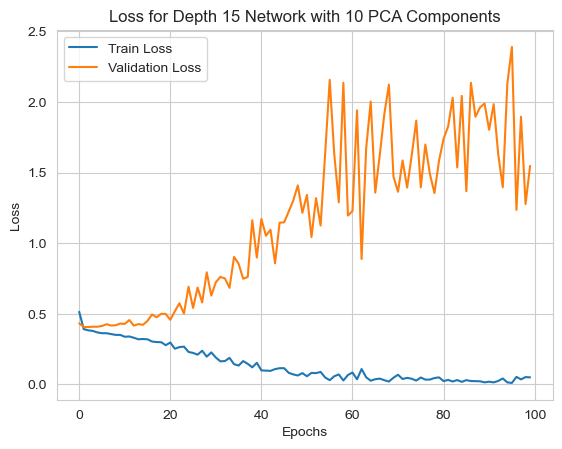

    Depth  F1-Score  PCA Components
0       5  0.028169               1
1       5  0.048780               2
2       5  0.141176               3
3       5  0.239316               4
4       5  0.245614               5
5       5  0.217391               6
6       5  0.220472               7
7       5  0.220472               8
8       5  0.118644               9
9       5  0.200000              10
10     10  0.028169               1
11     10  0.086957               2
12     10  0.176471               3
13     10  0.169811               4
14     10  0.302158               5
15     10  0.237288               6
16     10  0.192982               7
17     10  0.192000               8
18     10  0.200000               9
19     10  0.250000              10
20     15  0.028571               1
21     15  0.046512               2
22     15  0.196721               3
23     15  0.150943               4
24     15  0.336000               5
25     15  0.241935               6
26     15  0.192308         

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Load the dataset and preprocess it as you did before
file_path = 'cardio/data_cardiovascular_risk.csv'
data = pd.read_csv(file_path)

# Drop rows with missing values
data2 = data.dropna()

# Convert categorical columns into numerical labels
label_encoder = LabelEncoder()
data2['sex'] = label_encoder.fit_transform(data2['sex'])
data2['is_smoking'] = label_encoder.fit_transform(data2['is_smoking'])

# Drop the 'id' column and normalize the features in X
X = data2.drop(['id', 'TenYearCHD'], axis=1)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

y = data2['TenYearCHD']

# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Perform PCA
pca = PCA(n_components=10)  # Use the first 10 components for consistency
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Define and train the neural network with early stopping
def build_and_train_nn(depth, X_train, y_train, X_val, y_val):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    for _ in range(depth):
        model.add(layers.Dense(64, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=False)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])
    
    return model, history

depths = [5, 10, 15]
pca_components = range(1, 11)
results = []
models_history = {}  # Dictionary to store history data for each model

for depth in depths:
    for n_components in pca_components:
        pca_subset_X_train = X_train_pca[:, :n_components]
        pca_subset_X_val = X_val_pca[:, :n_components]
        
        model, history = build_and_train_nn(depth, pca_subset_X_train, y_train, pca_subset_X_val, y_val)
        models_history[(depth, n_components)] = (model, history)  # Store the model and history
        
        y_pred = (model.predict(X_test_pca[:, :n_components]) > 0.5).astype(int)
        f1 = f1_score(y_test, y_pred)
        
        results.append((depth, f1, n_components))
        
        plt.figure()
        plt.title(f'Loss for Depth {depth} Network with {n_components} PCA Components')
        
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        
        # Save the plot as an image
        plot_filename = f'cardio_PCA_loss_plot_depth_{depth}_components_{n_components}.png'
        plt.savefig(plot_filename)
        
        plt.close()  # Close the current figure to free up memory
        
        # Re-open the figure for showing the legend
        plt.figure()
        plt.title(f'Loss for Depth {depth} Network with {n_components} PCA Components')
        
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        
        # Show legend
        plt.legend()
        plt.show()

        
# Display results as a table
results_df = pd.DataFrame(results, columns=['Depth', 'F1-Score', 'PCA Components'])
print(results_df)


In [8]:
results_df

,Depth,F1-Score,PCA Components
0,5,0.028169,1
1,5,0.048780,2
2,5,0.141176,3
3,5,0.239316,4
4,5,0.245614,5
5,5,0.217391,6
6,5,0.220472,7
7,5,0.220472,8
8,5,0.118644,9
9,5,0.200000,10


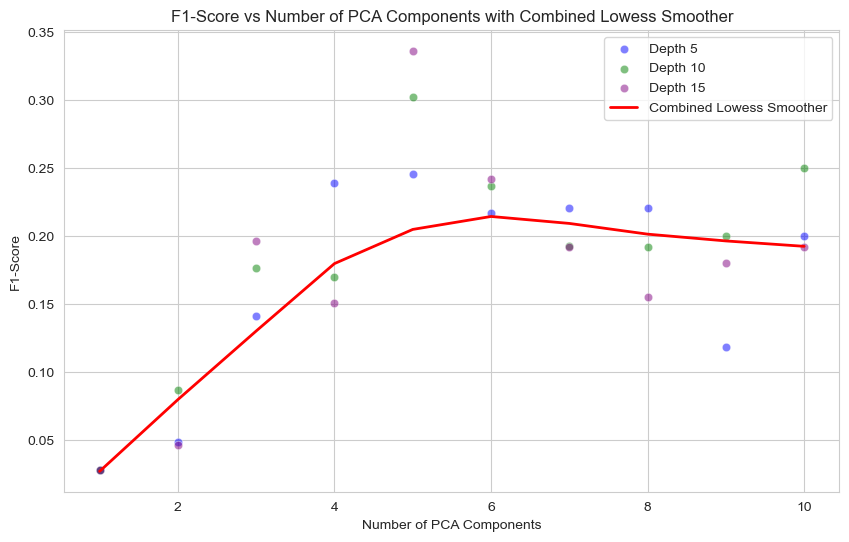

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Loop over different depths and assign a unique color
depth_colors = ['blue', 'green', 'purple']  # Add more colors if needed
for i, depth in enumerate(depths):
    depth_df = results_df[results_df['Depth'] == depth]
    sns.scatterplot(x='PCA Components', y='F1-Score', data=depth_df,
                    label=f'Depth {depth}', color=depth_colors[i], alpha=0.5)

# Compute the lowess smoother for all depths combined
combined_lowess = sm.nonparametric.lowess(results_df['F1-Score'], results_df['PCA Components'])
combined_lowess_x, combined_lowess_y = combined_lowess.T

# Plot the lowess smoother
plt.plot(combined_lowess_x, combined_lowess_y, color='red', label='Combined Lowess Smoother', linewidth=2)

plt.xlabel('Number of PCA Components')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Number of PCA Components with Combined Lowess Smoother')
plt.grid(True)
plt.legend()

# Save the figure
plt.savefig("f1_score_vs_num_pca_components_cardio_pca.png")

# Show the plot
plt.show()


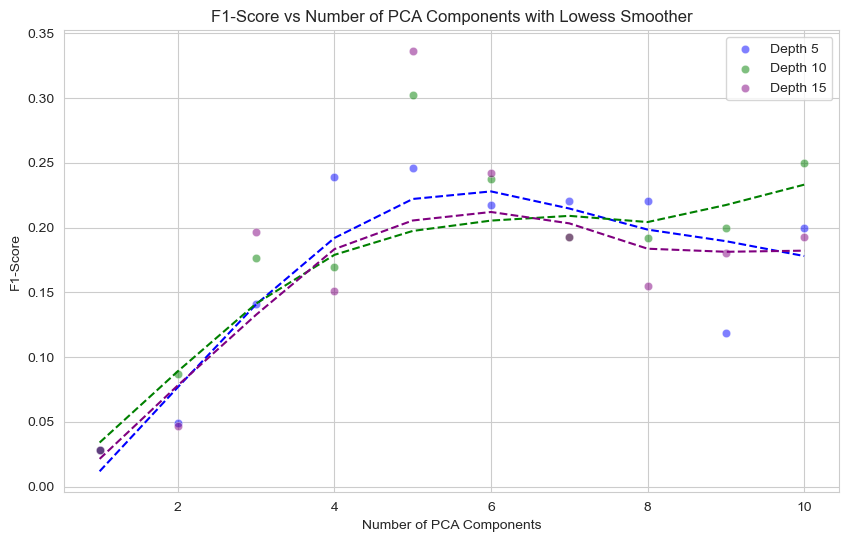

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Loop over different depths and assign a unique color
depth_colors = ['blue', 'green', 'purple']  # Add more colors if needed
for i, depth in enumerate(depths):
    depth_df = results_df[results_df['Depth'] == depth]
    sns.scatterplot(x='PCA Components', y='F1-Score', data=depth_df,
                    label=f'Depth {depth}', color=depth_colors[i], alpha=0.5)

    # Compute the lowess smoother
    lowess = sm.nonparametric.lowess(depth_df['F1-Score'], depth_df['PCA Components'])
    lowess_x, lowess_y = lowess.T

    # Plot the lowess smoother
    plt.plot(lowess_x, lowess_y, color=depth_colors[i], linestyle='--')

plt.xlabel('Number of PCA Components')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Number of PCA Components with Lowess Smoother')
plt.grid(True)
plt.legend()

# Save the figure
plt.savefig("f1_score_vs_num_pca_components_cardio_pca_split.png")

# Show the plot
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

pearson_corr, p_value = pearsonr(results_df['F1-Score'], results_df['PCA Components'])
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.5516133411392599
P-value: 0.001578864470986952
